# NLP processing of twitter tweets to detect disaster situations using scikit-learn 

Reusing code found online and then adapt and optimise it for the kaggle twitter dataset <br>
For **logistic regression** and **SVM** start-up code is https://towardsdatascience.com/sentiment-analysis-with-python-part-2-4f71e7bde59a <br>
For hyperparameter tuning : https://towardsdatascience.com/logistic-regression-model-tuning-with-scikit-learn-part-1-425142e01af5 <br>
Add other estimators : https://scikit-learn.org/stable/supervised_learning.html <br>

In [1]:
import numpy as np
import pandas as pd
import os
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score,roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,make_scorer

PUNCT_TO_REMOVE = string.punctuation
STOPWORDS = set(stopwords.words('english'))
stemmer = PorterStemmer()

# LOAD DATA SETS

In [3]:
# import training data (tweets)
df_train        = pd.read_csv(r'.\input\train.csv')
df_test         = pd.read_csv(r'.\input\test.csv')
perfect_pred_df = pd.read_csv(r'.\input\perfect_submission.csv')
# import test set target
perfect_pred    = perfect_pred_df.target

In [4]:
df_train.head(2)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1


# CLEAN DATA SETS

cleansing of train and data set

In [5]:
def text_cleaning(text):
    '''
    input: string to be cleaned
    output: cleaned string
    '''
    text = text.lower() # make everything lower case
    text = re.compile(r'https?://\S+|www\.\S+').sub(r'', text) #remove url
    text = re.compile(r'@\S+').sub(r'', text) #remove url
    text = re.compile(r'#').sub(r'', text) #remove #
#    text = text.translate(str.maketrans('', '', PUNCT_TO_REMOVE)) #remove punctuation
#    text = " ".join([word for word in str(text).split() if word not in STOPWORDS]) #remove stop words
#    text = " ".join([stemmer.stem(word) for word in text.split()])
    
    return text

In [6]:
# do the cleaning on text
df_train['text_processed'] = df_train['text'].apply(text_cleaning)
df_test['text_processed']  = df_test['text'].apply(text_cleaning)

In [7]:
df_test.text_processed.head(2)

0                   just happened a terrible car crash
1    heard about earthquake is different cities, st...
Name: text_processed, dtype: object

Make train and test set inputs (X) and targets (y) into lists

In [8]:
tweets_train_clean = df_train['text_processed'].tolist()
tweets_test_clean  = df_test['text_processed'].tolist() 

target_train       = df_train['target'].tolist()
target_test        = perfect_pred_df['target'].tolist()


# PRE-PROCESSING DATA FUNCTIONS

## Stop words removal

Stop words are the very common words like ‘if’, ‘but’, ‘we’, ‘he’, ‘she’, and ‘they’. <br>
We can usually remove these words without changing the semantics of a text and doing so often (but not always) improves the performance of a model. <br>
Removing these stop words becomes a lot more useful when we start using longer word sequences as model features (see n-grams below)

In [9]:
# import stopwords. Only need to do it once
#import nltk
#nltk.download("stopwords")

In [10]:
from nltk.corpus import stopwords

english_stop_words = stopwords.words('english')
def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        removed_stop_words.append(
            ' '.join([word for word in review.split() 
                      if word not in english_stop_words])
        )
    return removed_stop_words


## Stemming

Stemming is considered to be the more crude/brute-force approach to normalization (although this doesn’t necessarily mean that it will perform worse). There’s several algorithms, but in general they all use basic rules to chop off the ends of words.

NLTK has several stemming algorithm implementations. We’ll use the Porter stemmer here but you can explore all of the options with examples here: NLTK Stemmers

In [11]:
def get_stemmed_text(corpus):
    from nltk.stem.porter import PorterStemmer
    stemmer = PorterStemmer()

    return [' '.join([stemmer.stem(word) for word in review.split()]) for review in corpus]

## Lemmatization

Lemmatization works by identifying the part-of-speech of a given word and then applying more complex rules to transform the word into its true root.

In [12]:
# import wordnet. Only need to do it once
#import nltk
#nltk.download('wordnet')

In [13]:
def get_lemmatized_text(corpus):
    
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(word) for word in review.split()]) for review in corpus]


# n-grams

Basic processing uses only single word features in the model, which is called 1-grams or unigrams. <br> 
We can potentially add more predictive power to the model by adding two or three (or more) word sequences (bigrams or trigrams) as well.<br> 
For instance the tweet "just happened a terrible car crash" is transformed into following sets:<br>
1-grams: {'just'                     , 'happened'                , 'a'              , 'terrible'     , 'car'      , 'crash'} <br>
2-grams: {'just happened'            , 'happened a'              , 'a terrible'     , 'terrible car' , 'car crash'}<br> 
3-grams: {'just happened a'          , 'happened a terrible'     , 'a terrible car' , 'terrible car crash'}<br> 
4-grams: {'just happened a terrible' , 'happened a terrible car' , 'a terrible car crash'}<br> 


For example, if a movie review had the three word sequence “didn’t love movie” we would only consider these words individually with a unigram-only model and probably not capture that this is actually a negative sentiment because the word ‘love’ by itself is going to be highly correlated with a positive review.

The scikit-learn library makes this really easy to play around with. Just use the ngram argument in the function vectorize below

# Vectorization

Tweets are text and for this data to make sense to our machine learning algorithm we’ll need to convert each tweet to a numeric representation, which we call vectorization.

## Binary vectorization
The simplest form of vectorization is to create one very large matrix with one column for every unique word in your corpus (where the corpus is all tweets in our case). <br> 
Then we transform each tweet into one row containing 0s and 1s, where 1 means that the word in the corpus corresponding to that column appears in that tweet. <br> 
That being said, each row of the matrix will be very sparse (mostly zeros). <br> 
This process is also known as one hot encoding. <br> 
To use binary encoding, set binary parameter in the vectorize function to True

## Word Counts

Instead of simply noting whether a word appears in the tweet or not, we can include the number of times a given word appears. This can give our sentiment classifier a lot more predictive power. <br> 
For example, if a movie reviewer says ‘amazing’ or ‘terrible’ multiple times in a review it is considerably more probable that the review is positive or negative, respectively. <br> 
To use word count encoding, set binary parameter in the vectorize function to False

In [14]:
def vectorize(text_train,text_test, binary_or_count=True, ngram=(1,1)):
    vectorizer = CountVectorizer(binary=binary_or_count, ngram_range=ngram)
    vectorizer.fit(text_train)
    X = vectorizer.transform(text_train)
    X_test = vectorizer.transform(text_test)
    
    return(X,X_test)


## TF-IDF

Another common way to represent each document in a corpus is to use the tf-idf statistic (term frequency-inverse document frequency) for each word, which is a weighting factor that we can use in place of binary or word count representations. <br>

There are several ways to do tf-idf transformation but in a nutshell, tf-idf aims to represent the number of times a given word appears in a document (a tweet in our case) relative to the number of documents in the corpus that the word appears in — where words that appear in many documents have a value closer to zero and words that appear in less documents have values closer to 1. <br>
It can be intuitively understood as: <br>
* A word that would appear many times in a tweet but few times over all tweets would carry a lot meaning. <br>
* A word that would appear many times in a tweet and many times over all tweets would carry lot less meaning. <br>


TF-IDF is done by function TfidfVectorizer

## Pre-processing class

This class defines the kind of pre-processing to do <br>
it is broken down in 3 fields: <br>
1. stop_word. <br>
&nbsp;&nbsp;&nbsp;&nbsp;'keep'    : keep stop words<br>
&nbsp;&nbsp;&nbsp;&nbsp;'remove'  : remove stop words<br>
<br>
2. stem_lem <br>
&nbsp;&nbsp;&nbsp;&nbsp;'none'    : apply neither stemming not lemming <br>
&nbsp;&nbsp;&nbsp;&nbsp;'stem'    : apply stemming <br>
&nbsp;&nbsp;&nbsp;&nbsp;'lem'     : apply lemming <br>
<br>
3. ngram <br>
&nbsp;&nbsp;&nbsp;&nbsp;range of n-gram to compute
4. vector <br>
&nbsp;&nbsp;&nbsp;&nbsp;'binary'  : apply binary vectorization <br>
&nbsp;&nbsp;&nbsp;&nbsp;'count'   : apply words count vectorization <br>
&nbsp;&nbsp;&nbsp;&nbsp;'tf_idf'  : apply tf-idf vectorization <br>


In [15]:
class text_pre_preproc:
  def __init__(self, stop_word, stem_lem, ngram, vector):
    self.stop_word = stop_word
    self.stem_lem  = stem_lem
    self.ngram     = ngram
    self.vector    = vector

## Apply pre-processing function

This function performs pre-processing according to the fields of the class text_pre_preproc

In [16]:
def text_pre_processing(train_text, test_text, prep, verbose=0):
    '''
    input: train and test texts to be processed and pre_processing attributes
    output: vector of pre_processed train and test texts
    '''
    if verbose:
        print('text pre-processing parameters:')
        
    if   prep.stop_word == 'keep':
        if verbose:
            print('    keep stop words')
        train_stop_word, test_stop_word = (train_text                    , test_text)
    elif prep.stop_word =='remove':
        if verbose:
            print('    remove stop words')
        train_stop_word, test_stop_word = (remove_stop_words(train_text) , remove_stop_words(test_text))
    else:
        raise NameError('stop_word field from class text_pre_preproc not correctly set')
        
    if   prep.stem_lem == 'stem':
        if verbose:
            print('    do stemming')
        train_stem_lem, test_stem_lem = (get_stemmed_text(train_stop_word)    , get_stemmed_text(test_stop_word))
    elif prep.stem_lem == 'lem':
        if verbose:
            print('    do lemmatization')
        train_stem_lem, test_stem_lem = (get_lemmatized_text(train_stop_word) , get_lemmatized_text(test_stop_word))
    elif prep.stem_lem == 'none':
        if verbose:
            print('    no stemming or lemmatization')
        # do nothing
        train_stem_lem, test_stem_lem = (train_stop_word , test_stop_word)
    else:
        raise NameError('stem_lem field from class text_pre_preproc not correctly set')
            
    if   prep.vector == 'binary':
        if verbose:
            print('    binary vectorization with', prep.ngram[0], 'to', prep.ngram[1], "n-grams")
        train_vector, test_vector = vectorize(train_stem_lem, test_stem_lem, binary_or_count=True, ngram=prep.ngram)
    elif prep.vector == 'count':
        if verbose:
            print('    word count vectorization with', prep.ngram[0], 'to', prep.ngram[1], "n-grams")
        train_vector, test_vector = vectorize(train_stem_lem, test_stem_lem, binary_or_count=False, ngram=prep.ngram)
    elif prep.vector == 'tf_idf':
        if verbose:
            print('    tf-idf vectorization with', prep.ngram[0], 'to', prep.ngram[1], "n-grams")
        tfidf_vectorizer = TfidfVectorizer(ngram_range=prep.ngram)
        tfidf_vectorizer.fit(train_stem_lem)        
        train_vector, test_vector = (tfidf_vectorizer.transform(train_stem_lem) , tfidf_vectorizer.transform(test_stem_lem))
    else:
        raise NameError('vector field from class text_pre_preproc not correctly set')
    
    
    return (train_vector, test_vector) 

## Define pre_processing to do per algorithm

In [17]:
prep_list = [ 
                text_pre_preproc('keep','none',(1,1),'binary'),
                text_pre_preproc('remove','none',(1,1),'binary'),

                text_pre_preproc('keep','stem',(1,1),'binary'),
                text_pre_preproc('remove','stem',(1,1),'binary'),
    
                text_pre_preproc('keep','lem',(1,1),'binary'),
                text_pre_preproc('remove','lem',(1,1),'binary'),
     
                text_pre_preproc('keep','none',(1,2),'binary'),
                text_pre_preproc('remove','none',(1,2),'binary'),

                text_pre_preproc('keep','stem',(1,2),'binary'),
                text_pre_preproc('remove','stem',(1,2),'binary'),
    
                text_pre_preproc('keep','lem',(1,2),'binary'),
                text_pre_preproc('remove','lem',(1,2),'binary'),
     
                text_pre_preproc('keep','none',(1,3),'binary'),
                text_pre_preproc('remove','none',(1,3),'binary'),

                text_pre_preproc('keep','stem',(1,3),'binary'),
                text_pre_preproc('remove','stem',(1,3),'binary'),
    
                text_pre_preproc('keep','lem',(1,3),'binary'),
                text_pre_preproc('remove','lem',(1,3),'binary'),

                text_pre_preproc('keep','none',(2,3),'binary'),
                text_pre_preproc('remove','none',(2,3),'binary'),

                text_pre_preproc('keep','stem',(2,3),'binary'),
                text_pre_preproc('remove','stem',(2,3),'binary'),
    
                text_pre_preproc('keep','lem',(2,3),'binary'),
                text_pre_preproc('remove','lem',(2,3),'binary'),

                text_pre_preproc('keep','none',(1,1),'count'),
                text_pre_preproc('remove','none',(1,1),'count'),

                text_pre_preproc('keep','stem',(1,1),'count'),
                text_pre_preproc('remove','stem',(1,1),'count'),
    
                text_pre_preproc('keep','lem',(1,1),'count'),
                text_pre_preproc('remove','lem',(1,1),'count'),
     
                text_pre_preproc('keep','none',(1,2),'count'),
                text_pre_preproc('remove','none',(1,2),'count'),

                text_pre_preproc('keep','stem',(1,2),'count'),
                text_pre_preproc('remove','stem',(1,2),'count'),
    
                text_pre_preproc('keep','lem',(1,2),'count'),
                text_pre_preproc('remove','lem',(1,2),'count'),
     
                text_pre_preproc('keep','none',(1,3),'count'),
                text_pre_preproc('remove','none',(1,3),'count'),

                text_pre_preproc('keep','stem',(1,3),'count'),
                text_pre_preproc('remove','stem',(1,3),'count'),
    
                text_pre_preproc('keep','lem',(1,3),'count'),
                text_pre_preproc('remove','lem',(1,3),'count'),

                text_pre_preproc('keep','none',(2,3),'count'),
                text_pre_preproc('remove','none',(2,3),'count'),

                text_pre_preproc('keep','stem',(2,3),'count'),
                text_pre_preproc('remove','stem',(2,3),'count'),
    
                text_pre_preproc('keep','lem',(2,3),'count'),
                text_pre_preproc('remove','lem',(2,3),'count'),

                text_pre_preproc('keep','none',(1,1),'tf_idf'),
                text_pre_preproc('remove','none',(1,1),'tf_idf'),

                text_pre_preproc('keep','stem',(1,1),'tf_idf'),
                text_pre_preproc('remove','stem',(1,1),'tf_idf'),
    
                text_pre_preproc('keep','lem',(1,1),'tf_idf'),
                text_pre_preproc('remove','lem',(1,1),'tf_idf'),
     
                text_pre_preproc('keep','none',(1,2),'tf_idf'),
                text_pre_preproc('remove','none',(1,2),'tf_idf'),

                text_pre_preproc('keep','stem',(1,2),'tf_idf'),
                text_pre_preproc('remove','stem',(1,2),'tf_idf'),
    
                text_pre_preproc('keep','lem',(1,2),'tf_idf'),
                text_pre_preproc('remove','lem',(1,2),'tf_idf'),
     
                text_pre_preproc('keep','none',(1,3),'tf_idf'),
                text_pre_preproc('remove','none',(1,3),'tf_idf'),

                text_pre_preproc('keep','stem',(1,3),'tf_idf'),
                text_pre_preproc('remove','stem',(1,3),'tf_idf'),
    
                text_pre_preproc('keep','lem',(1,3),'tf_idf'),
                text_pre_preproc('remove','lem',(1,3),'tf_idf'),

                text_pre_preproc('keep','none',(2,3),'tf_idf'),
                text_pre_preproc('remove','none',(2,3),'tf_idf'),

                text_pre_preproc('keep','stem',(2,3),'tf_idf'),
                text_pre_preproc('remove','stem',(2,3),'tf_idf'),
    
                text_pre_preproc('keep','lem',(2,3),'tf_idf'),
                text_pre_preproc('remove','lem',(2,3),'tf_idf'),
    
            ]

In [ ]:
prep_list_rf = [     
                text_pre_preproc('remove','lem',(1,1),'binary'),
                text_pre_preproc('remove','lem',(1,2),'binary'),
                text_pre_preproc('remove','lem',(1,3),'binary'),
                text_pre_preproc('remove','lem',(2,3),'binary'),
                text_pre_preproc('remove','lem',(1,1),'count'),
                text_pre_preproc('remove','lem',(1,2),'count'),
                text_pre_preproc('remove','lem',(1,3),'count'),
                text_pre_preproc('remove','lem',(2,3),'count'),
                text_pre_preproc('remove','lem',(1,1),'tf_idf'),
                text_pre_preproc('remove','lem',(1,2),'tf_idf'),
                text_pre_preproc('remove','lem',(1,3),'tf_idf'),
                text_pre_preproc('remove','lem',(2,3),'tf_idf'),    
            ]

In [18]:
prep_algo_dic = {'lr':prep_list, 'svm':prep_list, 'rf':prep_list_rf}

In [19]:
def do_hyper_param(prep_list_algo , algo):
    best_hyper_param , best_accuracy, best_pred_soft , best_pred_hard = ([],[],[],[])
    prep_list = prep_algo_dic[algo]
    
    max_accuracy = -1
    for idx,prep in enumerate(prep_list):
        X,X_test = text_pre_processing(tweets_train_clean, tweets_test_clean, prep, verbose=1)
        
        if algo == 'lr':
            pipe, param_grid = logistic_regression_hyper_param()
        elif algo == 'svm':
            pipe, param_grid = SVM_hyper_param()
        elif algo == 'rf':
            pipe, param_grid = random_forest_hyper_param()
        else:
           raise NameError('incorrect algorithm name') 
            
        hyper_param , accuracy, pred_soft , pred_hard = hyper_param_tuning(X, target_train, X_test, target_test, pipe, param_grid)

        if accuracy >= max_accuracy:
            max_accuracy = accuracy 
            best_hyper_param , best_accuracy, best_pred_soft , best_pred_hard         = (hyper_param , accuracy, pred_soft , pred_hard)
            best_prep = prep_list[idx]
        print()
        
    return(best_hyper_param , best_accuracy, best_pred_soft , best_pred_hard, best_prep)

# Processing functions

## logistic regression function 

In [20]:
def display_results(y_test, pred_soft):
    preds = pred_soft[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='GridSearchCV (ROC_AUV (area) = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    #plt.savefig('Log_ROC')
    plt.show()

In [21]:
def hyper_param_tuning(X, y, X_test, y_test, pipe, param_grid):
    # Create grid search object
    clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=False, n_jobs=-1)

    # Fit on data
    best_clf         = clf.fit(X, y)
    
    best_hyper_param = best_clf.best_estimator_.get_params()['classifier']
    accuracy         = best_clf.score(X_test, y_test)
    # some models (e.g. clustering) have no soft predictions, only hard predictions
    try:
        pred_soft    = best_clf.predict_proba(X_test)
    except:
        pred_soft    = []
    pred_hard        = best_clf.predict(X_test)
    
#    print('Hyperparameter tuning leads to : ' , best_clf.best_estimator_.get_params()['classifier'])
    print('Model accuracy is', best_clf.score(X_test, y_test))
            
    return(best_hyper_param , accuracy, pred_soft , pred_hard)

# Logistic Regression Parameters

In [22]:
def logistic_regression_hyper_param():
    pipe = Pipeline([('classifier' , LogisticRegression())])

    # Create param grid.
    param_grid = [
                    {'classifier' : [LogisticRegression()],
                     'classifier__penalty' : ['l1', 'l2'],
#                     'classifier__max_iter' : [50, 100, 200, 500, 1000],
                    'classifier__C' : np.logspace(-4, 0, 40),
                    'classifier__solver' : ['liblinear']}
                ]
    
    return(pipe,param_grid)

# SVM Parameters

In [23]:
def SVM_hyper_param():
    pipe = Pipeline([('classifier' , LinearSVC())])

    # Create param grid.
    param_grid = [
                    {'classifier' : [LinearSVC()],
#                     'classifier__max_iter' : [50, 100, 200, 500, 1000],
                    'classifier__C' : np.logspace(-4, 0, 40),
                    'classifier__loss' : ['hinge','squared_hinge']
                    }
                ]
    
    return(pipe,param_grid)

# Random Forest Parameters

In [24]:
def random_forest_hyper_param():
    pipe = Pipeline([('classifier' , RandomForestClassifier())])

    # Create param grid.
    param_grid = [
                    {'classifier' : [RandomForestClassifier()],
                    'classifier__n_estimators' : list(range(10,101,10)),
                    'classifier__max_features' : list(range(6,32,5))}
                ]
    
    return(pipe,param_grid)

# RUN LOGISTIC REGRESSION

In [25]:
lr_best_hyper_param , lr_best_accuracy, lr_best_pred_soft , lr_best_pred_hard, lr_best_prep = do_hyper_param(prep_algo_dic , 'lr')

text pre-processing parameters:
    keep stop words
    no stemming or lemmatization
    binary vectorization with 1 to 1 n-grams
Model accuracy is 0.7876187557462457

text pre-processing parameters:
    remove stop words
    no stemming or lemmatization
    binary vectorization with 1 to 1 n-grams
Model accuracy is 0.796812749003984

text pre-processing parameters:
    keep stop words
    do stemming
    binary vectorization with 1 to 1 n-grams
Model accuracy is 0.7796506282562059

text pre-processing parameters:
    remove stop words
    do stemming
    binary vectorization with 1 to 1 n-grams
Model accuracy is 0.7891510879558689

text pre-processing parameters:
    keep stop words
    do lemmatization
    binary vectorization with 1 to 1 n-grams
Model accuracy is 0.774134232301563

text pre-processing parameters:
    remove stop words
    do lemmatization
    binary vectorization with 1 to 1 n-grams
Model accuracy is 0.8004903463070794

text pre-processing parameters:
    keep stop 

    do stemming
    tf-idf vectorization with 1 to 1 n-grams
Model accuracy is 0.7900704872816426

text pre-processing parameters:
    keep stop words
    do lemmatization
    tf-idf vectorization with 1 to 1 n-grams
Model accuracy is 0.7931351517008888

text pre-processing parameters:
    remove stop words
    do lemmatization
    tf-idf vectorization with 1 to 1 n-grams
Model accuracy is 0.7995709469813056

text pre-processing parameters:
    keep stop words
    no stemming or lemmatization
    tf-idf vectorization with 1 to 2 n-grams
Model accuracy is 0.8001838798651547

text pre-processing parameters:
    remove stop words
    no stemming or lemmatization
    tf-idf vectorization with 1 to 2 n-grams
Model accuracy is 0.7977321483297579

text pre-processing parameters:
    keep stop words
    do stemming
    tf-idf vectorization with 1 to 2 n-grams
Model accuracy is 0.8029420778424763

text pre-processing parameters:
    remove stop words
    do stemming
    tf-idf vectorization wit

C:\Users\nxa19765\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Model accuracy is 0.6769843702114618

text pre-processing parameters:
    remove stop words
    do stemming
    tf-idf vectorization with 2 to 3 n-grams
Model accuracy is 0.6754520380018388

text pre-processing parameters:
    keep stop words
    do lemmatization
    tf-idf vectorization with 2 to 3 n-grams
Model accuracy is 0.6736132393502912

text pre-processing parameters:
    remove stop words
    do lemmatization
    tf-idf vectorization with 2 to 3 n-grams
Model accuracy is 0.6763714373276126



best pre_processing is : { keep , lem , (1, 2) , tf_idf }
best model is  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
best accuracy is  0.806313208703647


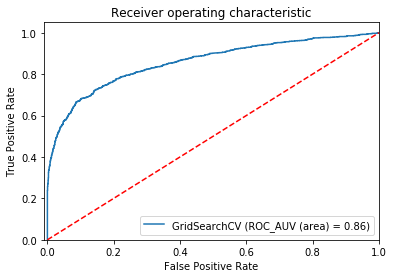

In [26]:
print('best pre_processing is :', '{',lr_best_prep.stop_word, ',' ,lr_best_prep.stem_lem, ',' ,lr_best_prep.ngram, ',' , lr_best_prep.vector ,'}') 
print('best model is ', lr_best_hyper_param)
print('best accuracy is ', lr_best_accuracy)
display_results(target_test, lr_best_pred_soft)

# RUN SVM

In [27]:
svm_best_hyper_param , svm_best_accuracy, svm_best_pred_soft , svm_best_pred_hard, svm_best_prep = do_hyper_param(prep_algo_dic , 'svm')

text pre-processing parameters:
    keep stop words
    no stemming or lemmatization
    binary vectorization with 1 to 1 n-grams
Model accuracy is 0.7946674839105118

text pre-processing parameters:
    remove stop words
    no stemming or lemmatization
    binary vectorization with 1 to 1 n-grams
Model accuracy is 0.7949739503524365

text pre-processing parameters:
    keep stop words
    do stemming
    binary vectorization with 1 to 1 n-grams
Model accuracy is 0.7836346920012258

text pre-processing parameters:
    remove stop words
    do stemming
    binary vectorization with 1 to 1 n-grams
Model accuracy is 0.7931351517008888

text pre-processing parameters:
    keep stop words
    do lemmatization
    binary vectorization with 1 to 1 n-grams
Model accuracy is 0.7781182960465829

text pre-processing parameters:
    remove stop words
    do lemmatization
    binary vectorization with 1 to 1 n-grams
Model accuracy is 0.8011032791909286

text pre-processing parameters:
    keep sto

KeyboardInterrupt: 

In [ ]:
print('best pre_processing is :', '{',svm_best_prep.stop_word, ',' ,svm_best_prep.stem_lem, ',' ,svm_best_prep.ngram, ',' , svm_best_prep.vector ,'}') 
print('best model is ', svm_best_hyper_param)
print('best accuracy is ', svm_best_accuracy)

# RUN RANDOM FOREST

In [ ]:
rf_best_hyper_param , rf_best_accuracy, rf_best_pred_soft , rf_best_pred_hard, rf_best_prep = do_hyper_param(prep_algo_dic , 'rf')

In [ ]:
print('best pre_processing is :', '{',rf_best_prep.stop_word, ',' ,rf_best_prep.stem_lem, ',' ,rf_best_prep.ngram, ',' , rf_best_prep.vector ,'}') 
print('best model is ', rf_best_hyper_param)
print('best accuracy is ', rf_best_accuracy)
display_results(target_test, rf_best_pred_soft)